E_in(g1): 0.24
alpha1: 0.5763397549691927
E_in(G): 0.0
U_2: 0.8541662601625051
U_T: 0.005401486582613611
E_out(g1): 0.29
E_out(G): 0.132


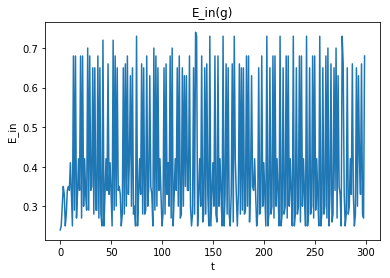

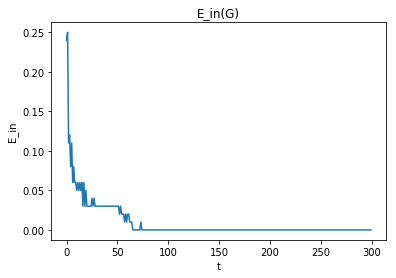

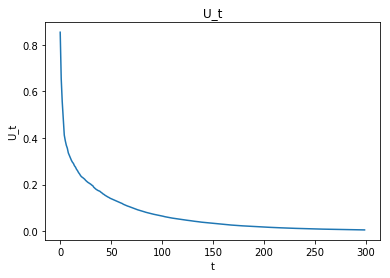

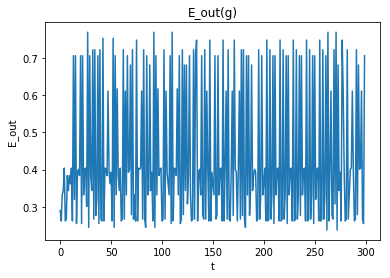

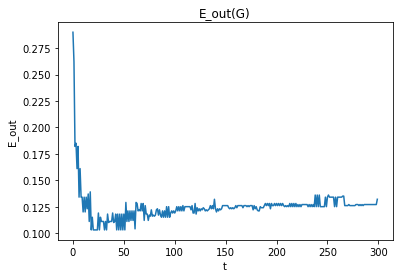

In [61]:
import numpy as np
import matplotlib.pyplot as plt

class adaboost_stump:
    def __init__(self, file, testFile):
        self.file = file
        self.x, self.y = self.load_data(file)
        self.x_test, self.y_test = self.load_data(testFile)
        self.iteration = 300
        
    def load_data(self, file):
        with open(file, 'r') as f:
            x = []
            y = []
            for line in f:
                line = line.split(' ')
                x.append([line[0],line[1]])
                y.append(line[2])
        return np.array(x).astype('float32'), np.array(y).astype('float32')
    
    def decision_stump(self,u):
        row, column = self.x.shape
        #print(row, column)
        s = [-1,1]
        besterr = 1000
        bestidx = -1
        bests = 0
        for j in range(column):
            #print(j)
            x_ = np.sort(self.x[:,j:j+1],0)
            #print(x_[0:5])
            tmp = [(x_[idx,0]+x_[idx+1,0])/2 for idx in range(row-1)]
            thres = np.r_[x_[0,0]-1, tmp] 
            #print(thres[0:5])
            
            for i in range(row):
                for sign in s:
                    pred = sign*np.sign(self.x[:,j] - np.tile(thres[i],row))
                    err = np.dot((pred != self.y).T, u)
                    if err < besterr:
                        besterr = err
                        bestidx = j
                        bests = sign
                        bestthres = thres[i]
        #print(besterr, bestidx, bests, bestthres)
        return besterr, bestidx, bests, bestthres
        
    def adaboost(self):
        row, column = self.x.shape
        row_test, column_test = self.x_test.shape
        u = np.array([1/row]*row)
        errs = []
        G_errs = []
        alphas = []
        ss = []
        idxs = []
        thress = []
        U = []
        E_outs = []
        gerrs = []
        for t in range(self.iteration):
            besterr, bestidx, bests, bestthres = self.decision_stump(u)
            #print(besterr, bestidx, bests, bestthres)
            ss.append(bests)
            idxs.append(bestidx)
            thress.append(bestthres)
            pred = bests*np.sign(self.x[:,bestidx] - np.tile(bestthres, row))
            g_pred = bests*np.sign(self.x_test[:,bestidx] - np.tile(bestthres, row_test))
            err = np.mean(pred != self.y)
            g_err = np.mean(g_pred != self.y_test)
            errs.append(err)
            gerrs.append(g_err)
            ep = np.sum(u*(pred!=self.y)) / np.sum(u)
            param = np.sqrt((1-ep)/ep)
            u[pred!=self.y] *= param
            u[pred==self.y] /= param
            U.append(np.sum(u))
            alphas.append(np.log(param))
            
            G_pred = self.predict(self.x, alphas, ss, idxs, thress)
            G_err = np.mean(G_pred != self.y)
            #print(G_err)
            G_errs.append(G_err)
            test_pred = self.predict(self.x_test, alphas, ss, idxs, thress)
            eout = np.mean(test_pred != self.y_test)
            E_outs.append(eout)
        return errs, alphas, ss, idxs, thress, G_errs, U, gerrs, E_outs
    
    def predict(self, x, alphas, ss, idxs, thress):
        row, column = x.shape
        pred = np.zeros((row,))
        for alpha, s, idx, thres in zip(alphas, ss, idxs, thress):
            pred += alpha*s*np.sign(x[:,idx]-np.tile(thres, row))

        return np.sign(pred)

        
a = adaboost_stump('hw3_train.dat.txt', 'hw3_test.dat.txt')
errs, alphas, ss, idxs, thress, G_errs, U, gerrs, E_outs = a.adaboost()

plt.figure()
plt.title('E_in(g)')
plt.xlabel('t')
plt.ylabel('E_in')
plt.plot(errs)
plt.savefig('Q11.png')

print('E_in(g1):', errs[0])
print('alpha1:', alphas[0])

plt.figure()
plt.title('E_in(G)')
plt.xlabel('t')
plt.ylabel('E_in')
plt.plot(G_errs)
plt.savefig('Q13.png')

print('E_in(G):', G_errs[-1])

plt.figure()
plt.title('U_t')
plt.xlabel('t')
plt.ylabel('U_t')
plt.plot(U)
plt.savefig('Q14.png')

print('U_2:', U[0])
print('U_T:', U[-1])

plt.figure()
plt.title('E_out(g)')
plt.xlabel('t')
plt.ylabel('E_out')
plt.plot(gerrs)
plt.savefig('Q15.png')

print('E_out(g1):', gerrs[0])

plt.figure()
plt.title('E_out(G)')
plt.xlabel('t')
plt.ylabel('E_out')
plt.plot(E_outs)
plt.savefig('Q16.png')

print('E_out(G):', E_outs[-1])